In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [3]:
import pandas as pd

In [10]:
from sklearn.model_selection import train_test_split

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
## load data csv
train_csv = pd.read_csv('./train.csv')
test_csv = pd.read_csv('./test.csv')

In [8]:
train_csv.head()

,img_path,upscale_img_path,label
0,./train/TRAIN_00000.jpg,./upscale_train/TRAIN_00000.png,Ruddy Shelduck
1,./train/TRAIN_00001.jpg,./upscale_train/TRAIN_00001.png,Gray Wagtail
2,./train/TRAIN_00002.jpg,./upscale_train/TRAIN_00002.png,Indian Peacock
3,./train/TRAIN_00003.jpg,./upscale_train/TRAIN_00003.png,Common Kingfisher
4,./train/TRAIN_00004.jpg,./upscale_train/TRAIN_00004.png,Common Kingfisher


In [35]:
width, height = 64, 64

In [13]:
ratation_val = 7
zoom_val = 0.2
horizontal_bool = True
vertical_bool = True
batch_num = 32

In [16]:
# train data generate
train_generator = ImageDataGenerator(rescale = 1./ 255,
                                    rotation_range = ratation_val,
                                    horizontal_flip=horizontal_bool,
                                    vertical_flip=vertical_bool,
                                    zoom_range= zoom_val,
                                    validation_split= 0.3) # 30% 는 학습 데이터로 분류

train_dataset = train_generator.flow_from_dataframe(train_csv, x_col= 'img_path', y_col= 'label',
                                                   target_size= (width, height),
                                                    batch_size = batch_num,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                    subset='training',
                                                   seed = 2)
validation_dataset = train_generator.flow_from_dataframe(train_csv, x_col= 'img_path', y_col= 'label',
                                                   target_size= (width, height),
                                                    batch_size = batch_num,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                    subset='validation',
                                                   seed = 2)

Found 11084 validated image filenames belonging to 25 classes.
Found 4750 validated image filenames belonging to 25 classes.


<AxesSubplot:ylabel='count'>

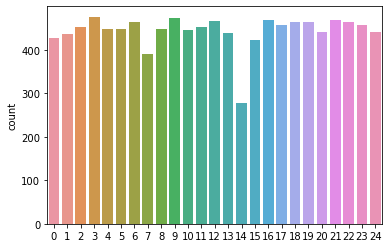

In [18]:
sns.countplot(x = train_dataset.classes)

<AxesSubplot:ylabel='count'>

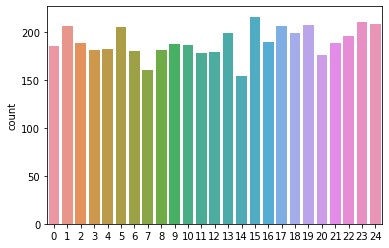

In [19]:
sns.countplot(x = validation_dataset.classes)

In [40]:
num_detectors = 32
num_classes = 25
epochs = 50


In [41]:
# 모델 생성

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_41 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)       

In [42]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# validation accuracy가 향상되지 않으면 학습을 조기 중지합니다.
# `monitor`는 "val_accuracy"를, `patience`는 20번의 epoch를 초과할 때 중지하도록 설정합니다.
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # 20번의 epoch 동안 향상되지 않으면 중지
    restore_best_weights=True  # 최적의 가중치를 복원
)

In [43]:
network.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
347/347 [==============================] - 137s 393ms/step - loss: 3.3233 - accuracy: 0.0829 - val_loss: 3.7538 - val_accuracy: 0.0406
Epoch 2/50
347/347 [==============================] - 136s 393ms/step - loss: 2.9500 - accuracy: 0.1352 - val_loss: 2.8265 - val_accuracy: 0.1613
Epoch 3/50
347/347 [==============================] - 140s 403ms/step - loss: 2.6840 - accuracy: 0.1996 - val_loss: 2.6220 - val_accuracy: 0.2246
Epoch 4/50
347/347 [==============================] - 140s 402ms/step - loss: 2.5036 - accuracy: 0.2531 - val_loss: 2.4658 - val_accuracy: 0.2533
Epoch 5/50
347/347 [==============================] - 142s 410ms/step - loss: 2.3587 - accuracy: 0.2811 - val_loss: 2.3122 - val_accuracy: 0.2979
Epoch 6/50
347/347 [==============================] - 140s 404ms/step - loss: 2.2598 - accuracy: 0.3154 - val_loss: 2.3486 - val_accuracy: 0.3080
Epoch 7/50
347/347 [==============================] - 138s 398ms/step - loss: 2.1472 - accuracy: 0.3602 - val_loss: 2.3251 -

In [44]:
model_json = network.to_json()
with open('second_complex_model.json','w') as json_file:
  json_file.write(model_json)

In [45]:
from keras.models import save_model
network_saved = save_model(network, 'weight_sencond_birds.hdf5')

open

In [46]:
with open('second_complex_model.json', 'r') as json_file:
  json_saved_model = json_file.read()

network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weight_sencond_birds.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [47]:
network_loaded.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_41 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)       

In [52]:
submision_csv = pd.read_csv('sample_submission.csv')
submision_csv.head()

,id,label
0,TEST_00000,Indian Roller
1,TEST_00001,Indian Roller
2,TEST_00002,Indian Roller
3,TEST_00003,Indian Roller
4,TEST_00004,Indian Roller


In [53]:
test_csv

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg
...,...,...
6781,TEST_06781,./test/TEST_06781.jpg
6782,TEST_06782,./test/TEST_06782.jpg
6783,TEST_06783,./test/TEST_06783.jpg
6784,TEST_06784,./test/TEST_06784.jpg


In [66]:
test_generator = ImageDataGenerator(rescale = 1./ 255)

test_dataset = test_generator.flow_from_dataframe(test_csv, x_col= 'img_path', # y_col= 'label',
                                                   target_size= (width, height),
                                                    batch_size = 1,
                                                   class_mode = None ,
                                                   shuffle = False)

Found 6786 validated image filenames.


In [67]:
prediction = network_loaded.predict(test_dataset)
prediction

array([[1.9427484e-02, 9.0705762e-03, 3.1995226e-04, ..., 2.1334626e-03,
        5.9535272e-02, 6.7041241e-05],
       [8.7246346e-01, 1.2806159e-02, 1.7557158e-04, ..., 3.0996892e-04,
        1.2620459e-03, 1.3345405e-03],
       [2.7184785e-04, 2.6798712e-03, 1.1377201e-03, ..., 1.0259064e-03,
        4.7261343e-05, 1.1452303e-02],
       ...,
       [3.2600368e-05, 4.7398262e-05, 1.1785170e-01, ..., 1.0346075e-03,
        6.0172752e-05, 2.3662983e-03],
       [3.1940215e-06, 2.6560531e-04, 1.9945044e-04, ..., 1.3682585e-03,
        6.0684673e-05, 5.4553348e-05],
       [3.0899528e-08, 3.7248685e-07, 1.6505838e-10, ..., 7.3629338e-09,
        8.4170509e-08, 3.4665411e-12]], dtype=float32)

In [68]:
prediction.shape

(6786, 25)

In [69]:
pred_max = np.argmax(prediction, axis = 1)
pred_max

array([ 7,  0, 16, ..., 21, 10,  7], dtype=int64)

In [70]:
pred_max.shape

(6786,)

In [62]:
# 클래스 이름과 정수 레이블의 매핑을 확인합니다.
class_indices = train_dataset.class_indices
print("Class indices:", class_indices)

# 매핑을 사용하여 정수 레이블을 원래의 라벨로 변환합니다.
def convert_label(int_label):
    for class_name, index in class_indices.items():
        if index == int_label:
            return class_name
    return None

# 예측 결과에서 정수 레이블을 받은 후 원래의 라벨로 변환
predicted_int_label = 3  # 예시로 정수 레이블을 사용
predicted_class_name = convert_label(predicted_int_label)
print(f"Predicted class name: {predicted_class_name}")

Class indices: {'Asian Green Bee-Eater': 0, 'Brown-Headed Barbet': 1, 'Cattle Egret': 2, 'Common Kingfisher': 3, 'Common Myna': 4, 'Common Rosefinch': 5, 'Common Tailorbird': 6, 'Coppersmith Barbet': 7, 'Forest Wagtail': 8, 'Gray Wagtail': 9, 'Hoopoe': 10, 'House Crow': 11, 'Indian Grey Hornbill': 12, 'Indian Peacock': 13, 'Indian Pitta': 14, 'Indian Roller': 15, 'Jungle Babbler': 16, 'Northern Lapwing': 17, 'Red-Wattled Lapwing': 18, 'Ruddy Shelduck': 19, 'Rufous Treepie': 20, 'Sarus Crane': 21, 'White Wagtail': 22, 'White-Breasted Kingfisher': 23, 'White-Breasted Waterhen': 24}
Predicted class name: Common Kingfisher


In [71]:
pred_val = np.array([convert_label(i) for i in pred_max])
pred_val.shape

(6786,)

In [64]:
result = pd.read_csv('sample_submission.csv')
result

,id,label
0,TEST_00000,Indian Roller
1,TEST_00001,Indian Roller
2,TEST_00002,Indian Roller
3,TEST_00003,Indian Roller
4,TEST_00004,Indian Roller
...,...,...
6781,TEST_06781,Indian Roller
6782,TEST_06782,Indian Roller
6783,TEST_06783,Indian Roller
6784,TEST_06784,Indian Roller


In [ ]:
result['label'] = pred_val
result

In [78]:
result.to_csv("second_result.csv", index=False)
data = pd.read_csv("second_result.csv")
print(data)

              id                      label
0     TEST_00000         Coppersmith Barbet
1     TEST_00001      Asian Green Bee-Eater
2     TEST_00002             Jungle Babbler
3     TEST_00003                Sarus Crane
4     TEST_00004                Sarus Crane
...          ...                        ...
6781  TEST_06781  White-Breasted Kingfisher
6782  TEST_06782               Gray Wagtail
6783  TEST_06783                Sarus Crane
6784  TEST_06784                     Hoopoe
6785  TEST_06785         Coppersmith Barbet

[6786 rows x 2 columns]


In [79]:
# pickle 저장
import pickle

In [82]:
with open('training_dataset.pickle', 'wb') as f:
    pickle.dump(train_dataset, f)

TypeError: cannot pickle '_thread.lock' object

In [81]:
with open('training_dataset.pickle', 'rb') as f:
    data = pickle.load(f)
data

EOFError: Ran out of input